In [287]:
# First run the following packages

import requests
import time
import tqdm
import pandas as pd
import os
import json
import openpyxl
from pathlib import Path
from zipfile import ZipFile
import matplotlib.pyplot as plt
import numpy as np
from numpy import NaN
import seaborn as sns
from bs4 import BeautifulSoup

In [278]:
# This is the code for the Ridge model

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# This code load the data. However, make sure to change the csv_file_path url

csv_file_path = r"C:\Users\dschu\OneDrive\Documenten\output.csv"
df = pd.read_csv(csv_file_path)
df['datetime'] = pd.to_datetime(df['datetime'])

# Defines the features and target variable
X = df.drop(['price', 'year built', 'postal_code'], axis=1)
y = df['price']

# Defines the polynomial degrees and lambda values. You could change the polynomial 'degrees' object to e.g., degrees = [2, 3] or degrees = [2] or degrees = [3]
degrees = [3]
lambdas = np.logspace(-4, 4, 12)

# TimeSeriesSplit arguments. We use 4 splits (or folds) and a gap of about 90 days
n_splits = 4
gap = 90
tscv = TimeSeriesSplit(n_splits=n_splits, gap=gap)

# Creates empy list to store results
results = []

# Loops through polynomial degree(s) and lambdas (which we defined above)
for degree in degrees:
    for lambda_ in lambdas:
        fold_mses = []
        for train_idx, test_idx in tscv.split(X):
            X_train, y_train = X.iloc[train_idx], y[train_idx]
            X_test, y_test = X.iloc[test_idx], y[test_idx]
            
            # Separates numeric and datetime features, as we're dealing with time series data
            numeric_features = X_train.select_dtypes(include=[np.number]).columns
            datetime_features = X_train.select_dtypes(include=[np.datetime64]).columns
            
            # Automatic engineering and preprocessing for numeric features
            poly_transformer_numeric = PolynomialFeatures(degree=degree, include_bias=False)
            X_train_numeric_poly = poly_transformer_numeric.fit_transform(X_train[numeric_features])
            X_test_numeric_poly = poly_transformer_numeric.transform(X_test[numeric_features])
            
            # Automatic engineering and preprocessing for datetime features
            poly_transformer_datetime = PolynomialFeatures(degree=degree, include_bias=False)
            X_train_datetime_poly = poly_transformer_datetime.fit_transform(X_train[datetime_features])
            X_test_datetime_poly = poly_transformer_datetime.transform(X_test[datetime_features])
            
            # Combine the results using the .concatenate method
            X_train_poly = np.concatenate((X_train_numeric_poly, X_train_datetime_poly), axis=1)
            X_test_poly = np.concatenate((X_test_numeric_poly, X_test_datetime_poly), axis=1)
            
            # Standardizes the features, as we want 0 mean
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_poly)
            X_test_scaled = scaler.transform(X_test_poly)
            
            # Creates and trains the actual model with the defined range of Lambda values
            ridge_model = Ridge(alpha=lambda_, random_state=1)
            ridge_model.fit(X_train_scaled, y_train)
            
            # Model evaluation
            y_pred = ridge_model.predict(X_test_scaled)
            fold_mse = mean_squared_error(y_test, y_pred)
            fold_mses.append(fold_mse)
        
        avg_mse = np.mean(fold_mses)
        results.append(['RIDGE', f'{degree}-deg', avg_mse, lambda_])

# Creates a DataFrame to display the results
columns = ["Model", "Polynomial Degree", "Avg MSE", "Lambda"]
results_df = pd.DataFrame(results, columns=columns)
print(results_df)

# Finds the index of the row with the lowest Avg MSE
min_mse_idx = results_df['Avg MSE'].idxmin()

# Gets the best model's details
best_model = results_df.loc[min_mse_idx]

print("\nBest Model:")
print(best_model)

    Model Polynomial Degree       Avg MSE        Lambda
0   RIDGE             3-deg  8.824933e+15      0.000100
1   RIDGE             3-deg  2.571190e+14      0.000534
2   RIDGE             3-deg  7.108527e+13      0.002848
3   RIDGE             3-deg  5.732300e+14      0.015199
4   RIDGE             3-deg  3.621501e+14      0.081113
5   RIDGE             3-deg  1.054114e+14      0.432876
6   RIDGE             3-deg  1.352160e+13      2.310130
7   RIDGE             3-deg  8.141841e+12     12.328467
8   RIDGE             3-deg  9.820772e+12     65.793322
9   RIDGE             3-deg  1.096237e+12    351.119173
10  RIDGE             3-deg  1.310785e+12   1873.817423
11  RIDGE             3-deg  7.110718e+11  10000.000000

Best Model:
Model                              RIDGE
Polynomial Degree                  3-deg
Avg MSE              711071791435.583862
Lambda                           10000.0
Name: 11, dtype: object


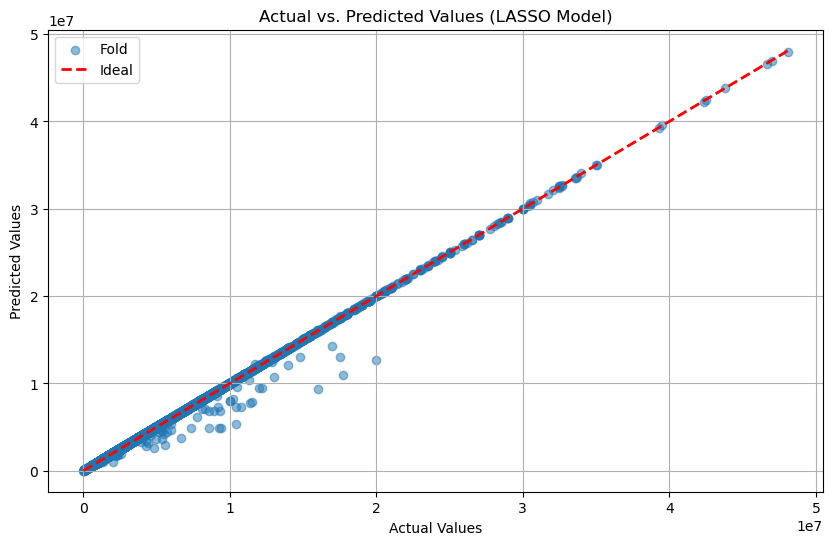

<Figure size 640x480 with 0 Axes>

In [283]:
# Visualization of the best model 'LASSO' 2-degrees (see code below for the results of the LASSO models)

import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

# This code load the data. However, make sure to change the csv_file_path url
csv_file_path = r"C:\Users\dschu\OneDrive\Documenten\output.csv"
df = pd.read_csv(csv_file_path)
df['datetime'] = pd.to_datetime(df['datetime'])

# Defines the features and target variable
X = df.drop(['price', 'year built', 'postal_code'], axis=1)
y = df['price']

# Best model parameters, which we calculated in the code below (see LASSO model)
best_degree = 2
best_lambda = 1873.817423

# TimeSeriesSplit arguments. We use 4 splits (or folds) and a gap of about 90 days
n_splits = 4
gap = 90
tscv = TimeSeriesSplit(n_splits=n_splits, gap=gap)

# Empty lists to store actual and predicted values
actual_values = []
predicted_values = []

# Loop through lambdas
for lambda_ in [best_lambda]:
    for train_idx, test_idx in tscv.split(X):
        X_train, y_train = X.iloc[train_idx], y[train_idx]
        X_test, y_test = X.iloc[test_idx], y[test_idx]
        
        # Separates numeric and datetime features
        numeric_features = X_train.select_dtypes(include=[np.number]).columns
        datetime_features = X_train.select_dtypes(include=[np.datetime64]).columns
        
        # Feature engineering and preprocessing for numeric features
        poly_transformer_numeric = PolynomialFeatures(degree=best_degree, include_bias=False)
        X_train_numeric_poly = poly_transformer_numeric.fit_transform(X_train[numeric_features])
        X_test_numeric_poly = poly_transformer_numeric.transform(X_test[numeric_features])
        
        # Feature engineering and preprocessing for datetime features
        poly_transformer_datetime = PolynomialFeatures(degree=best_degree, include_bias=False)
        X_train_datetime_poly = poly_transformer_datetime.fit_transform(X_train[datetime_features])
        X_test_datetime_poly = poly_transformer_datetime.transform(X_test[datetime_features])
        
        # Combine the results of the step above
        X_train_poly = np.concatenate((X_train_numeric_poly, X_train_datetime_poly), axis=1)
        X_test_poly = np.concatenate((X_test_numeric_poly, X_test_datetime_poly), axis=1)
        
        # Standardizes the features, as we want 0 mean
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_poly)
        X_test_scaled = scaler.transform(X_test_poly)
        
        # Model creation and training
        lasso_model = Lasso(alpha=lambda_, random_state=1)
        lasso_model.fit(X_train_scaled, y_train)
        
        # Model evaluation
        y_pred = lasso_model.predict(X_test_scaled)
        
        # Store actual and predicted values for this fold
        actual_values.extend(y_test)
        predicted_values.extend(y_pred)

# Plotting the predicted values against the actual values
plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predicted_values, label="Fold", alpha=0.5)
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--', linewidth=2, label="Ideal")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values (LASSO Model)")
plt.legend()
plt.grid(True)
plt.show()

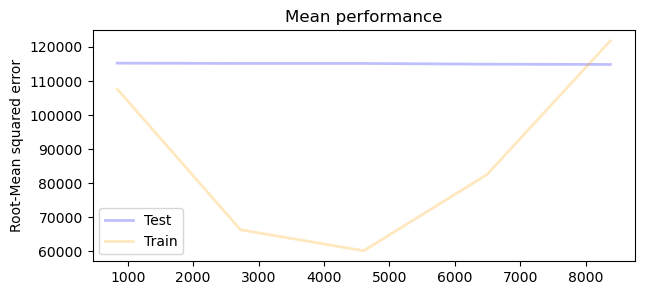

In [285]:
# Visualization of the **learning curve** best model (LASSO, 2 degrees)

import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, learning_curve
import matplotlib.pyplot as plt

# This code load the data. However, make sure to change the csv_file_path url
csv_file_path = r"C:\Users\dschu\OneDrive\Documenten\output.csv"
df = pd.read_csv(csv_file_path)
df['datetime'] = pd.to_datetime(df['datetime'])

# Defines the features and target variable
X = df.drop(['price', 'year built', 'postal_code'], axis=1)
y = df['price']

# Best model parameters
best_degree = 2
best_alpha = 1873.817423

# TimeSeriesSplit arguments. We use 4 splits (or folds) and a gap of about 90 days
n_splits = 4
gap = 90
tscv = TimeSeriesSplit(n_splits=n_splits, gap=gap)

# Empty lists to store actual and predicted values
actual_values = []
predicted_values = []

# Loop through alphas
for alpha in [best_alpha]:  # Changed to 'alpha' for Lasso
    for train_idx, test_idx in tscv.split(X):
        X_train, y_train = X.iloc[train_idx], y[train_idx]
        X_test, y_test = X.iloc[test_idx], y[test_idx]
        
        # Separate numeric and datetime features
        numeric_features = X_train.select_dtypes(include=[np.number]).columns
        datetime_features = X_train.select_dtypes(include=[np.datetime64]).columns
        
        # Feature engineering and preprocessing for numeric features
        poly_transformer_numeric = PolynomialFeatures(degree=best_degree, include_bias=False)
        X_train_numeric_poly = poly_transformer_numeric.fit_transform(X_train[numeric_features])
        X_test_numeric_poly = poly_transformer_numeric.transform(X_test[numeric_features])
        
        # Feature engineering and preprocessing for datetime features
        poly_transformer_datetime = PolynomialFeatures(degree=best_degree, include_bias=False)
        X_train_datetime_poly = poly_transformer_datetime.fit_transform(X_train[datetime_features])
        X_test_datetime_poly = poly_transformer_datetime.transform(X_test[datetime_features])
        
        # Combines the results of the above step
        X_train_poly = np.concatenate((X_train_numeric_poly, X_train_datetime_poly), axis=1)
        X_test_poly = np.concatenate((X_test_numeric_poly, X_test_datetime_poly), axis=1)
        
        # Standardize the features, as we want 0 mean
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_poly)
        X_test_scaled = scaler.transform(X_test_poly)
        
        # Model creation and training
        lasso_model = Lasso(alpha=alpha, random_state=1)
        lasso_model.fit(X_train_scaled, y_train)
        
        # Model evaluation
        y_pred = lasso_model.predict(X_test_scaled)
        
        # Store actual and predicted values for this fold
        actual_values.extend(y_test)
        predicted_values.extend(y_pred)

# Calculate the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    lasso_model, X_train_scaled, y_train, train_sizes=np.linspace(0.1, 1.0, 5),
    scoring='neg_mean_squared_error', cv=tscv, n_jobs=-1
)

# Create the learning curve plot
f_learn, ax = plt.subplots(figsize=(7, 3))
ax.plot(train_sizes, np.sqrt(-test_scores.mean(1)), alpha=0.25, linewidth=2, label='Test', color='blue')
ax.plot(train_sizes, np.sqrt(-train_scores.mean(1)), alpha=0.25, linewidth=2, label='Train', color='orange')

ax.set_title('Mean performance')
ax.set_ylabel('Root-Mean squared error')
ax.legend()
plt.show()

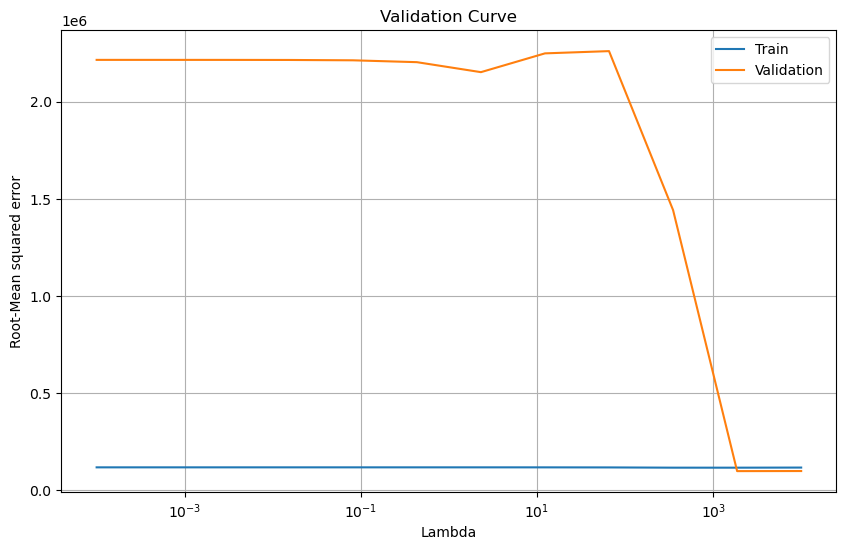

In [286]:
# **Validation curve** for the best model (LASSO)

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, validation_curve
import matplotlib.pyplot as plt

# This code load the data. However, make sure to change the csv_file_path url
csv_file_path = r"C:\Users\dschu\OneDrive\Documenten\output.csv"
df = pd.read_csv(csv_file_path)
df['datetime'] = pd.to_datetime(df['datetime'])

# Defines the features and target variable
X = df.drop(['price', 'year built', 'postal_code'], axis=1)
y = df['price']

# Best model parameter (poly. degrees)
best_degree = 2

# Define lambda values
lambdas = np.logspace(-4, 4, 12)

# TimeSeriesSplit arguments. We use 4 splits (or folds) and a gap of about 90 days
n_splits = 4
gap = 90
tscv = TimeSeriesSplit(n_splits=n_splits, gap=gap)

# Empty lists to store results
train_scores = []
test_scores = []

# Loop through lambdas
for lambda_ in lambdas:
    fold_train_scores = []
    fold_test_scores = []
    for train_idx, test_idx in tscv.split(X):
        X_train, y_train = X.iloc[train_idx], y[train_idx]
        X_test, y_test = X.iloc[test_idx], y[test_idx]
        
        # Separate numeric and datetime features
        numeric_features = X_train.select_dtypes(include=[np.number]).columns
        datetime_features = X_train.select_dtypes(include=[np.datetime64]).columns
        
        # Feature engineering and preprocessing for numeric features
        poly_transformer_numeric = PolynomialFeatures(degree=best_degree, include_bias=False)
        X_train_numeric_poly = poly_transformer_numeric.fit_transform(X_train[numeric_features])
        X_test_numeric_poly = poly_transformer_numeric.transform(X_test[numeric_features])
        
        # Feature engineering and preprocessing for datetime features
        poly_transformer_datetime = PolynomialFeatures(degree=best_degree, include_bias=False)
        X_train_datetime_poly = poly_transformer_datetime.fit_transform(X_train[datetime_features])
        X_test_datetime_poly = poly_transformer_datetime.transform(X_test[datetime_features])
        
        # Combine the results
        X_train_poly = np.concatenate((X_train_numeric_poly, X_train_datetime_poly), axis=1)
        X_test_poly = np.concatenate((X_test_numeric_poly, X_test_datetime_poly), axis=1)
        
        # Standardize the features, as we want 0 mean
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_poly)
        X_test_scaled = scaler.transform(X_test_poly)
        
        # Model creation and training
        lasso_model = Lasso(alpha=lambda_, random_state=1)
        lasso_model.fit(X_train_scaled, y_train)
        
        # Model evaluation
        y_train_pred = lasso_model.predict(X_train_scaled)
        y_test_pred = lasso_model.predict(X_test_scaled)
        
        # Calculate mean squared error
        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)
        
        fold_train_scores.append(train_mse)
        fold_test_scores.append(test_mse)
    
    train_scores.append(fold_train_scores)
    test_scores.append(fold_test_scores)

# Converts lists to arrays
train_scores = np.array(train_scores)
test_scores = np.array(test_scores)

# Calculates mean scores for each lambda
mean_train_scores = train_scores.mean(axis=1)
mean_test_scores = test_scores.mean(axis=1)

# Creates the validation curve plot
plt.figure(figsize=(10, 6))
plt.semilogx(lambdas, np.sqrt(mean_train_scores), label='Train')
plt.semilogx(lambdas, np.sqrt(mean_test_scores), label='Validation')
plt.xlabel('Lambda')
plt.ylabel('Root-Mean squared error')
plt.title('Validation Curve')
plt.legend()
plt.grid(True)
plt.show()


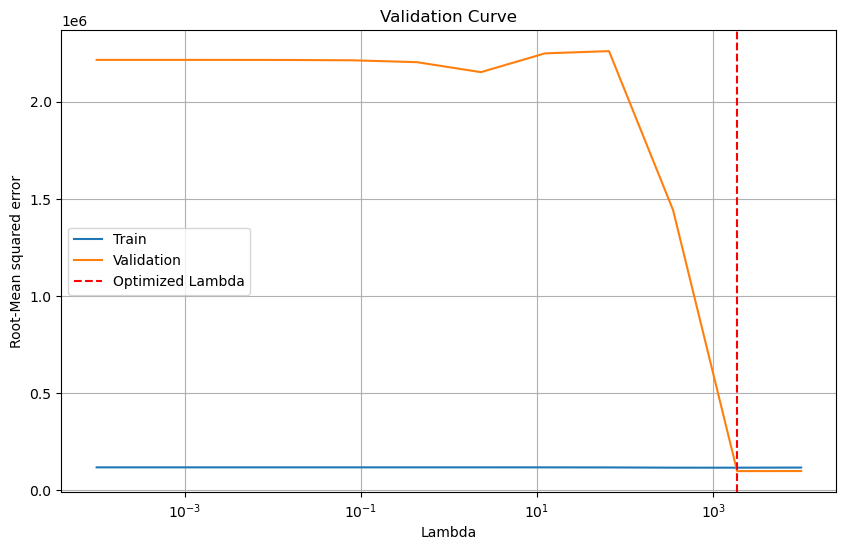

In [290]:
# Validation curve of the best LASSO model (which is exactly the same as above, but) with dotted line

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, validation_curve
import matplotlib.pyplot as plt

# This code load the data. However, make sure to change the csv_file_path url
csv_file_path = r"C:\Users\dschu\OneDrive\Documenten\output.csv"
df = pd.read_csv(csv_file_path)
df['datetime'] = pd.to_datetime(df['datetime'])

# Defines the features and target variable
X = df.drop(['price', 'year built', 'postal_code'], axis=1)
y = df['price']

# Best model parameter (poly. degrees)
best_degree = 2

# Define lambda values
lambdas = np.logspace(-4, 4, 12)

# TimeSeriesSplit arguments. We use 4 splits (or folds) and a gap of about 90 days
n_splits = 4
gap = 90
tscv = TimeSeriesSplit(n_splits=n_splits, gap=gap)

# Empty lists to store results
train_scores = []
test_scores = []

# Loop through lambdas
for lambda_ in lambdas:
    fold_train_scores = []
    fold_test_scores = []
    for train_idx, test_idx in tscv.split(X):
        X_train, y_train = X.iloc[train_idx], y[train_idx]
        X_test, y_test = X.iloc[test_idx], y[test_idx]
        
        # Separate numeric and datetime features
        numeric_features = X_train.select_dtypes(include=[np.number]).columns
        datetime_features = X_train.select_dtypes(include=[np.datetime64]).columns
        
        # Feature engineering and preprocessing for numeric features
        poly_transformer_numeric = PolynomialFeatures(degree=best_degree, include_bias=False)
        X_train_numeric_poly = poly_transformer_numeric.fit_transform(X_train[numeric_features])
        X_test_numeric_poly = poly_transformer_numeric.transform(X_test[numeric_features])
        
        # Feature engineering and preprocessing for datetime features
        poly_transformer_datetime = PolynomialFeatures(degree=best_degree, include_bias=False)
        X_train_datetime_poly = poly_transformer_datetime.fit_transform(X_train[datetime_features])
        X_test_datetime_poly = poly_transformer_datetime.transform(X_test[datetime_features])
        
        # Combine the results
        X_train_poly = np.concatenate((X_train_numeric_poly, X_train_datetime_poly), axis=1)
        X_test_poly = np.concatenate((X_test_numeric_poly, X_test_datetime_poly), axis=1)
        
        # Standardize the features, as we want 0 mean
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_poly)
        X_test_scaled = scaler.transform(X_test_poly)
        
        # Model creation and training
        lasso_model = Lasso(alpha=lambda_, random_state=1)
        lasso_model.fit(X_train_scaled, y_train)
        
        # Model evaluation
        y_train_pred = lasso_model.predict(X_train_scaled)
        y_test_pred = lasso_model.predict(X_test_scaled)
        
        # Calculate mean squared error
        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)
        
        fold_train_scores.append(train_mse)
        fold_test_scores.append(test_mse)
    
    train_scores.append(fold_train_scores)
    test_scores.append(fold_test_scores)

# Converts lists to arrays
train_scores = np.array(train_scores)
test_scores = np.array(test_scores)

# Calculates mean scores for each lambda
mean_train_scores = train_scores.mean(axis=1)
mean_test_scores = test_scores.mean(axis=1)

# Creates the validation curve plot
plt.figure(figsize=(10, 6))
plt.semilogx(lambdas, np.sqrt(mean_train_scores), label='Train')
plt.semilogx(lambdas, np.sqrt(mean_test_scores), label='Validation')

# Adds a vertical dotted line for the optimized lambda
best_alpha = 1873.817423
plt.axvline(x=best_alpha, color='red', linestyle='dashed', label='Optimized Lambda')

plt.xlabel('Lambda')
plt.ylabel('Root-Mean squared error')
plt.title('Validation Curve')
plt.legend()
plt.grid(True)
plt.show()


In [277]:
# Lasso model

import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

# This code load the data. However, make sure to change the csv_file_path url
csv_file_path = r"C:\Users\dschu\OneDrive\Documenten\output.csv"
df = pd.read_csv(csv_file_path)
df['datetime'] = pd.to_datetime(df['datetime'])

# Defines the features and target variable
X = df.drop(['price', 'year built', 'postal_code'], axis=1)
y = df['price'] #CHANGE BACK TO PRICE

# Defines polynomial degrees and lambda values
degrees = [2, 3] # In this case, we set it to 2 and 3. But you could change it to whatever you like. However, the Lasso model takes time to run. This computing time increases as poly. degrees are set higher.
lambdas = np.logspace(-4, 4, 12)

# Initializes TimeSeriesSplit with suitable parameters
n_splits = 4
gap = 90
tscv = TimeSeriesSplit(n_splits=n_splits, gap=gap)

# Initializes empty list to store results
results = []

# Loop through polynomial degrees and lambdas
for degree in degrees:
    for lambda_ in lambdas:
        fold_mses = []
        for train_idx, test_idx in tscv.split(X):
            X_train, y_train = X.iloc[train_idx], y[train_idx]
            X_test, y_test = X.iloc[test_idx], y[test_idx]
            
            # Separate numeric and datetime features
            numeric_features = X_train.select_dtypes(include=[np.number]).columns
            datetime_features = X_train.select_dtypes(include=[np.datetime64]).columns
            
            # Feature engineering and preprocessing for numeric features
            poly_transformer_numeric = PolynomialFeatures(degree=degree, include_bias=False)
            X_train_numeric_poly = poly_transformer_numeric.fit_transform(X_train[numeric_features])
            X_test_numeric_poly = poly_transformer_numeric.transform(X_test[numeric_features])
            
            # Feature engineering and preprocessing for datetime features
            poly_transformer_datetime = PolynomialFeatures(degree=degree, include_bias=False)
            X_train_datetime_poly = poly_transformer_datetime.fit_transform(X_train[datetime_features])
            X_test_datetime_poly = poly_transformer_datetime.transform(X_test[datetime_features])
            
            # Combines the results
            X_train_poly = np.concatenate((X_train_numeric_poly, X_train_datetime_poly), axis=1)
            X_test_poly = np.concatenate((X_test_numeric_poly, X_test_datetime_poly), axis=1)
            
            # Standardizes the features, as we want 0 mean
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_poly)
            X_test_scaled = scaler.transform(X_test_poly)
            
            # Model creation and training
            lasso_model = Lasso(alpha=lambda_, random_state=1)
            lasso_model.fit(X_train_scaled, y_train)
            
            # Model evaluation
            y_pred = lasso_model.predict(X_test_scaled)
            fold_mse = mean_squared_error(y_test, y_pred)
            fold_mses.append(fold_mse)
        
        avg_mse = np.mean(fold_mses)
        results.append(['LASSO', f'{degree}-deg', avg_mse, lambda_])

# Creates a DataFrame to display the results
columns = ["Model", "Polynomial Degree", "Avg MSE", "Lambda"]
results_df = pd.DataFrame(results, columns=columns)
print(results_df)

# Finds the index of the row with the lowest Avg MSE
min_mse_idx = results_df['Avg MSE'].idxmin()

# Gets the best model's details
best_model = results_df.loc[min_mse_idx]

print("\nBest Model:")
print(best_model)


    Model Polynomial Degree       Avg MSE        Lambda
0   LASSO             2-deg  4.905868e+12      0.000100
1   LASSO             2-deg  4.905816e+12      0.000534
2   LASSO             2-deg  4.905538e+12      0.002848
3   LASSO             2-deg  4.904052e+12      0.015199
4   LASSO             2-deg  4.896124e+12      0.081113
5   LASSO             2-deg  4.853850e+12      0.432876
6   LASSO             2-deg  4.630011e+12      2.310130
7   LASSO             2-deg  5.055422e+12     12.328467
8   LASSO             2-deg  5.107515e+12     65.793322
9   LASSO             2-deg  2.078932e+12    351.119173
10  LASSO             2-deg  9.700939e+09   1873.817423
11  LASSO             2-deg  9.788103e+09  10000.000000
12  LASSO             3-deg  1.536686e+14      0.000100
13  LASSO             3-deg  1.536671e+14      0.000534
14  LASSO             3-deg  1.536594e+14      0.002848
15  LASSO             3-deg  1.536184e+14      0.015199
16  LASSO             3-deg  1.534007e+14      0

In [293]:
# Best model (Lasso) with **weights** as output

import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

# This code load the data. However, make sure to change the csv_file_path url
csv_file_path = r"C:\Users\dschu\OneDrive\Documenten\output.csv"
df = pd.read_csv(csv_file_path)
df['datetime'] = pd.to_datetime(df['datetime'])

# Defines the features and target variable
X = df.drop(['price', 'year built', 'postal_code'], axis=1)
y = df['price']  # Change back to 'price'

# Best model parameters (of LASSO model)
best_degree = 2
best_lambda = 1873.817423

# Initializes TimeSeriesSplit with suitable parameters
n_splits = 4
gap = 90
tscv = TimeSeriesSplit(n_splits=n_splits, gap=gap)

# Creates empty list to store results
results = []

# Loop through polynomial degrees and lambdas
for degree in [best_degree]:
    for lambda_ in [best_lambda]:
        fold_mses = []
        for train_idx, test_idx in tscv.split(X):
            X_train, y_train = X.iloc[train_idx], y[train_idx]
            X_test, y_test = X.iloc[test_idx], y[test_idx]

            # Separate numeric and datetime features
            numeric_features = X_train.select_dtypes(include=[np.number]).columns
            datetime_features = X_train.select_dtypes(include=[np.datetime64]).columns

            # Feature engineering and preprocessing for numeric features
            poly_transformer_numeric = PolynomialFeatures(degree=degree, include_bias=False)
            X_train_numeric_poly = poly_transformer_numeric.fit_transform(X_train[numeric_features])
            X_test_numeric_poly = poly_transformer_numeric.transform(X_test[numeric_features])

            # Feature engineering and preprocessing for datetime features
            poly_transformer_datetime = PolynomialFeatures(degree=degree, include_bias=False)
            X_train_datetime_poly = poly_transformer_datetime.fit_transform(X_train[datetime_features])
            X_test_datetime_poly = poly_transformer_datetime.transform(X_test[datetime_features])

            # Combines the results
            X_train_poly = np.concatenate((X_train_numeric_poly, X_train_datetime_poly), axis=1)
            X_test_poly = np.concatenate((X_test_numeric_poly, X_test_datetime_poly), axis=1)

            # Standardizes the features as we want 0 mean
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_poly)
            X_test_scaled = scaler.transform(X_test_poly)

            # Model creation and training
            lasso_model = Lasso(alpha=lambda_, random_state=1)
            lasso_model.fit(X_train_scaled, y_train)

            # Model evaluation
            y_pred = lasso_model.predict(X_test_scaled)
            fold_mse = mean_squared_error(y_test, y_pred)
            fold_mses.append(fold_mse)

        avg_mse = np.mean(fold_mses)
        results.append(['LASSO', f'{degree}-deg', avg_mse, lambda_])

# Finds the index of the row with the lowest Avg MSE
min_mse_idx = np.argmin([result[2] for result in results])

# Gets the best model's details
best_model = results[min_mse_idx]
print("\nBest Model:")
print(best_model)

# Retrieves the coefficients (weights) of the best LASSO model
best_alpha = best_model[3]
best_lasso_model = Lasso(alpha=best_alpha, random_state=1)
best_lasso_model.fit(X_train_scaled, y_train)  # Assuming you've defined X_train_scaled and y_train
coefficients = best_lasso_model.coef_

print("\nBest Model Coefficients:")
print(coefficients)


Best Model:
['LASSO', '2-deg', 9700939201.834549, 1873.817423]

Best Model Coefficients:
[-0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  9.44622708e+03  1.63987872e+04  0.00000000e+00 -1.09191769e+03
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  2.49022147e+06 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00]


In [295]:
# Follow up of the code above

# Retrieves the coefficients (weights) of the best LASSO model
best_alpha = best_model[3]
best_lasso_model = Lasso(alpha=best_alpha, random_state=1)
best_lasso_model.fit(X_train_scaled, y_train)
coefficients = best_lasso_model.coef_

# Retrieves the feature names
numeric_feature_names = X.columns

coefficients_dict = {}
for feature_name, coefficient in zip(numeric_feature_names, coefficients):
    coefficients_dict[feature_name] = coefficient

for feature_name, coefficient in coefficients_dict.items():
    print(f"{feature_name}: {coefficient}")


rooms: -0.0
kr/m2: 0.0
m2: -0.0
datetime: -0.0
Loan interest rate: 0.0
Inflation: -0.0
Salary: -0.0
GDP: 0.0
category: 9446.227081436948


In [ ]:
# End of the notebook!